# Comparison:   Upsample+Conv   vs   TransposeConv

Using TransposeConv for upsampling on the Generator might produce a checkboard effect visible on the output images, this effect can be greatly reduced by using Upsample+Conv instead.
<br></br><br></br>
Source: https://distill.pub/2016/deconv-checkerboard/
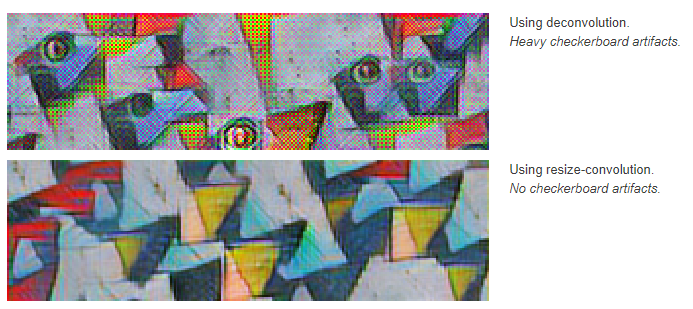

In [ ]:
#imports
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('../input/annotation/Annotation/',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)

                    bbox = (xmin, ymin, xmax, ymax)

                    object_img = required_transforms(img.crop(bbox))
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)

In [ ]:
# util functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.)

def plot_loss(G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, NZ, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)

    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()

In [ ]:
# initialize training variables/load image data
kernel_start_time = time.perf_counter()
database = "../input/all-dogs/all-dogs/"
n_samples = 2000 #np.inf
BATCH_SIZE = 16
EPOCHS = 31
use_soft_noisy_labels = True
invert_labels = False
SHOW_DATA = True

transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=BATCH_SIZE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NZ = 100
criterion = nn.BCELoss()

In [ ]:
# train model loop
def train_loop():
    G_losses = []
    D_losses = []
    print("Training Model")
    for epoch in range(EPOCHS):
        if time.perf_counter() - kernel_start_time > 32000:
            print("Time limit reached! Stopping kernel!"); break
            
        start = time.time()
        for ii, real_images in enumerate(train_loader):
            if real_images.shape[0]!= BATCH_SIZE:
                continue
            
            # create labels for the data
            if use_soft_noisy_labels:
                real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(0.80, 0.95))
                fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(0.05, 0.20))
            else:
                real_labels = torch.squeeze(torch.full((BATCH_SIZE, 1), 0.95, device=device))
                fake_labels = torch.squeeze(torch.full((BATCH_SIZE, 1), 0.05, device=device))
                
            if invert_labels:
                real_labels, fake_labels = fake_labels, real_labels
            
            
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real samples
            netD.zero_grad()
            real_images = real_images.to(device)
            output = netD(real_images)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            
            # train with fake samples
            noise = torch.randn(BATCH_SIZE, NZ, 1, 1, device=device)
            fake = netG(noise)
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            errD = errD_real + errD_fake
            optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
       
        #print(f"{time.time() - start:.2f}s [{epoch + 1}/{EPOCHS}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")
        
        if SHOW_DATA and (epoch) % 10 == 0:
            #plot_loss(G_losses, D_losses, epoch)
            show_generated_img(10)
        G_losses = []; D_losses = []

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

netD = Discriminator().to(device)
weights_init(netD)
optimizerD = optim.Adam(netD.parameters(), lr=0.0005, betas=(0.5, 0.999))

# Generator -> TransposeConvolutions

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.05),
            
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.05),
            
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.05),
            
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(negative_slope=0.05),
            
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator().to(device)
weights_init(netG)
optimizerG = optim.Adam(netG.parameters(), lr=0.0010, betas=(0.5, 0.999))

train_loop()

# Generator -> Upsample(bilinear) + Convolution(3x3)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def up_conv_block(n_input, n_output, mode='bilinear', k_size=3, stride=1, padding=1):
            return [nn.Upsample(scale_factor=2, mode=mode),
                    nn.Conv2d(n_input, n_output, k_size, stride=stride, padding=padding),
                    nn.BatchNorm2d(n_output),
                    nn.LeakyReLU(negative_slope=0.05),
                   ]
            
        self.model = nn.Sequential(
                        nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0),
                        nn.BatchNorm2d(512),
            
                        *up_conv_block(512, 256, mode='bilinear', k_size=3, stride=1, padding=1),
                        *up_conv_block(256, 128, mode='bilinear', k_size=3, stride=1, padding=1),
                        *up_conv_block(128, 64,  mode='bilinear', k_size=3, stride=1, padding=1),
            
                        nn.Upsample(scale_factor=2, mode='bilinear'),
                        nn.Conv2d(64,  3,   3, stride=1, padding=1),
                        nn.Tanh(),
                        )
        
    def forward(self, x):
        return self.model(x)


netG = Generator().to(device)
weights_init(netG)
optimizerG = optim.Adam(netG.parameters(), lr=0.0010, betas=(0.5, 0.999))
    
train_loop()

Try it out! Any comment on the results obtained would really be appreciated.